In [1]:
from typing import Any, Tuple

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

In [2]:
class MyDataset(Dataset):
    def __init__(self, path_to_annot_file: str, transform: Any=None, train: bool=None, test: bool=None, valid: bool=None) -> None:
        self.path_to_annot_file = path_to_annot_file
        self.data = self.get_data(path_to_annot_file, train, test, valid)
        self.transform = transform

    def get_data(self, path_to_annot_file: str, train: bool=None, test: bool=None, valid: bool=None):
        data = pd.read_csv(path_to_annot_file, usecols = (0, 2), names = ('path_to_image', 'label'))
        data = data.sample(frac=1).reset_index(drop=True)
        data['label'] = data['label'].apply(lambda label: 0 if label == 'polarbear' else 1)
        train_size = int(0.8 * data.shape[0])
        test_valid_size = int(0.1 * data.shape[0])
        if train == True:
            data = data.iloc[:train_size, :]
        elif test == True:
            data = data.iloc[train_size:train_size + test_valid_size, :]
        elif valid == True:
            data = data.iloc[train_size + test_valid_size:, :]
        return data

    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
        path_to_image = self.data.iloc[index, 0]
        image = cv2.cvtColor(cv2.imread(path_to_image), cv2.COLOR_BGR2RGB)
        label = self.data.iloc[index, 1]

        if self.transform:
            image = self.transform(image)
        
        return image, label


In [3]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize((224, 224)),
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [4]:
train_data = MyDataset(path_to_annot_file='paths.csv', transform=transforms, train = True)
test_data = MyDataset(path_to_annot_file='paths.csv', transform=transforms, test = True)
valid_data = MyDataset(path_to_annot_file='paths.csv', transform=transforms, valid = True)

In [5]:
len(train_data), len(test_data), len(valid_data)

(1604, 200, 202)

In [6]:
train_data.data['label'].value_counts()

label
0    807
1    797
Name: count, dtype: int64

In [7]:
test_data.data['label'].value_counts()

label
0    100
1    100
Name: count, dtype: int64

In [8]:
valid_data.data['label'].value_counts()

label
0    104
1     98
Name: count, dtype: int64

In [9]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,
                                stride = 2)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                                stride = 2)
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,
                                stride = 2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.max_pool = nn.MaxPool2d(2)

        self.fully_connect1 = nn.Linear(576, 10)
        self.fully_connect2 = nn.Linear(10, 1)

    def forward(self, x:torch.tensor) -> torch.tensor:
        output = self.relu(self.conv_1(x))
        output = self.max_pool(output)
        output = self.relu(self.conv_2(output))
        output = self.max_pool(output)
        output = self.relu(self.conv_3(output))
        output = self.max_pool(output)

        output = torch.nn.Flatten()(output)
        output = self.relu(self.fully_connect1(output))
        output = torch.nn.Sigmoid()(self.fully_connect2(output))
        return output

In [10]:
batch_size = 4

In [11]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle = True)
valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle = True)

C:\Users\WWolk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for 

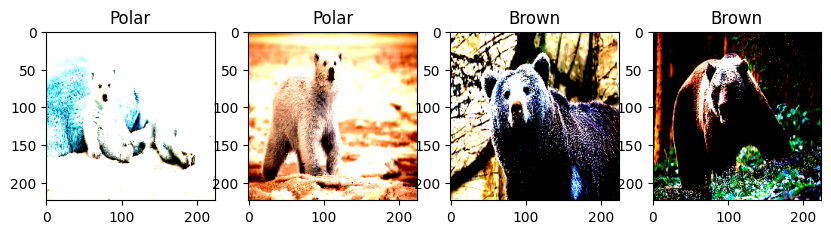

In [12]:
plt.figure(figsize = (10, 5))

for i, sample_batched in enumerate(train_loader):
    if i == 1:
        break
    for j in range(batch_size):
        plt.subplot(1, 4, j + 1)
        plt.title('Polar' if sample_batched[1][j] == 0 else 'Brown')
        plt.imshow(sample_batched[0][j].permute(1, 2, 0).numpy()[:, :, ::-1])

In [31]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [32]:
model = CNN().to(device)

In [33]:
device

device(type='cpu')

In [34]:
'''
parameters = {'lr': [0.0001, 0.001, 0.01],
              'batch_size' : [5, 10, 30]}
'''
parameters = {'lr': [0.001],
              'batch_size' : [10]}


In [44]:
for lr in parameters['lr']:
    optimizer = optim.Adam(params=model.parameters(), lr=lr)
    criterion = nn.BCELoss(reduction='sum')
    for bs in parameters['batch_size']:
        train_loader = DataLoader(dataset=train_data, batch_size=bs, shuffle = True)
        test_loader = DataLoader(dataset=test_data, batch_size=bs, shuffle = False)
        valid_loader = DataLoader(dataset=valid_data, batch_size=bs, shuffle = False)

        epochs = 2

        train_accuracy_values = []
        train_loss_values = []

        val_accuracy_values = []
        val_loss_values = []

        test_accuracy_values = []
        test_loss_values = []

        for epoch in range(epochs):
            epoch_loss = 0
            epoch_accuracy = 0
            
            epoch_val_loss = 0
            epoch_val_accuracy = 0

            for data, label in train_loader:
                data = data.to(device)
                label = label.to(device)
                
                output = model(data)
                loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                acc = ((output.argmax(dim=1) == label).float().mean())

                epoch_accuracy += acc / len(train_data)
                epoch_loss += loss / len(train_data)

            #model.eval()
            with torch.no_grad():
                for data, label in valid_loader:
                    data = data.to(device)
                    label = label.to(device)

                    output = model(data)
                    loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))
                    acc = ((output.argmax(dim=1) == label).float().mean())

                    epoch_val_accuracy += acc / len(valid_data)
                    epoch_val_loss += loss / len(valid_data)
            
            val_accuracy_values.append(epoch_val_accuracy)
            val_loss_values.append(epoch_val_loss)

            train_accuracy_values.append(epoch_accuracy)
            train_loss_values.append(epoch_loss)

            print('Epoch: {}, train_accuracy: {}, train_loss: {}'.format(epoch + 1, epoch_accuracy, epoch_loss))
        
        '''
        Иначе не отрисуется график
        У val_loss_values этого делать не нужно, так как with no_grad()
        '''
        train_loss_values = [value.detach() for value in train_loss_values]

        plt.figure(figsize=(12,10)) 

        plt.subplot(2, 1, 1)
        plt.title("Train")
        plt.plot(range(1, epochs + 1), train_accuracy_values, color = 'green')
        plt.plot(range(1, epochs + 1), train_loss_values, color = 'blue')
        plt.legend(['Accuracy', 'Loss'])

        plt.subplot(2, 1, 2)
        plt.title("Valid")
        plt.plot(range(1, epochs + 1), val_accuracy_values, color = 'green')
        plt.plot(range(1, epochs + 1), val_loss_values, color = 'blue')
        plt.legend(['Accuracy', 'Loss'])
        
        #model.eval()

        test_loss = 0
        test_accuracy = 0

        with torch.no_grad():
            for data, label in test_loader:
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

                acc = ((output.argmax(dim=1) == label).float().mean())

                test_accuracy+=acc / len(test_data)
                test_loss+=loss / len(test_data)

        test_accuracy_values.append(test_accuracy)
        test_loss_values.append(test_loss)  

Epoch: 1, train_accuracy: 0.05049879848957062, train_loss: 0.0314042903482914
Epoch: 2, train_accuracy: 0.05049879103899002, train_loss: 0.014590585604310036


In [59]:
train_loss_values = [value.detach() for value in train_loss_values]

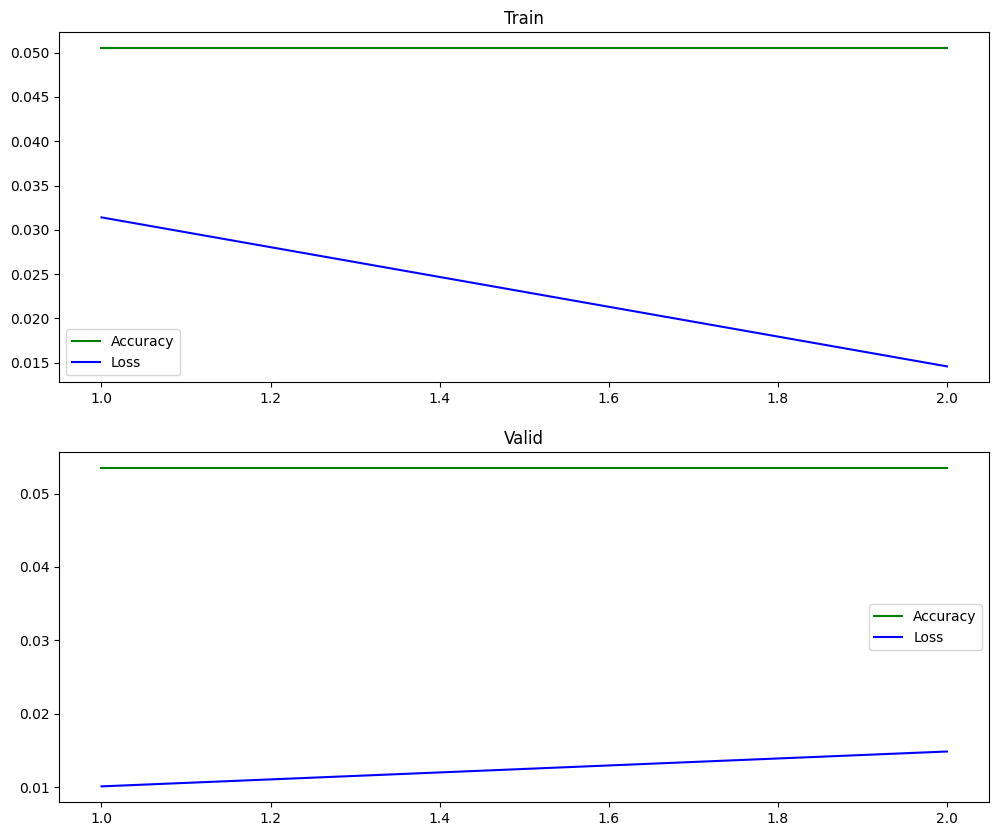

In [60]:
plt.figure(figsize=(12,10)) 

plt.subplot(2, 1, 1)
plt.title("Train")
plt.plot(range(1, epochs + 1), train_accuracy_values, color = 'green')
plt.plot(range(1, epochs + 1), train_loss_values, color = 'blue')
plt.legend(['Accuracy', 'Loss'])
  
plt.subplot(2, 1, 2)
plt.title("Valid")
plt.plot(range(1, epochs + 1), val_accuracy_values, color = 'green')
plt.plot(range(1, epochs + 1), val_loss_values, color = 'blue')
plt.legend(['Accuracy', 'Loss'])

In [65]:
test_accuracy_values[0], test_loss_values[0]

(tensor(0.0500), tensor(0.0145))